<a href="https://colab.research.google.com/github/awaisrauf/explorations/blob/main/robust_applications_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adversarial Generation

Taken from [robustness library](https://github.com/MadryLab/robustness_applications).

In [ ]:
!wget http://andrewilyas.com/CIFAR.pt
!git clone https://github.com/MadryLab/robustness_applications.git

--2022-04-27 06:01:25--  http://andrewilyas.com/CIFAR.pt
Resolving andrewilyas.com (andrewilyas.com)... 52.218.234.170
Connecting to andrewilyas.com (andrewilyas.com)|52.218.234.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188522353 (180M) [binary/octet-stream]
Saving to: ‘CIFAR.pt’

CIFAR.pt            100%[===================>] 179.79M  11.7MB/s    in 17s     

2022-04-27 06:01:42 (10.5 MB/s) - ‘CIFAR.pt’ saved [188522353/188522353]



In [ ]:
!pip install torch==1.8.1 torchvision==0.9.1

In [ ]:
# !cd robustness_applications
%cd robustness_applications
!pip install -r requirements.txt

In [ ]:
!pip install robustness

In [ ]:
%cd robustness_applications

/content/robustness_applications


In [ ]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [ ]:
# Constants
DATA = 'CIFAR' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NUM_CLASSES_VIS = 10

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1 
NUM_CLASSES_VIS = min(NUM_CLASSES_VIS, NUM_CLASSES)
GRAIN = 4 if DATA != 'CIFAR' else 1

In [ ]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /tmp/cifar-10-python.tar.gz to /tmp/
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/CIFAR.pt'
=> loaded checkpoint './models/CIFAR.pt' (epoch 153)


AttackerModel(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, mo

In [ ]:
def downsample(x, step=GRAIN):
    down = ch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = ch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

In [ ]:
# Get seed distribution (can be memory intensive to do all ImageNet classes at once)

im_test, targ_test = [], []
for _, (im, targ) in enumerate(test_loader):
    im_test.append(im)
    targ_test.append(targ)
im_test, targ_test = ch.cat(im_test), ch.cat(targ_test)

conditionals = []
for i in tqdm(range(NUM_CLASSES_VIS)):
    imc = im_test[targ_test == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*ch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
    conditionals.append(dist)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


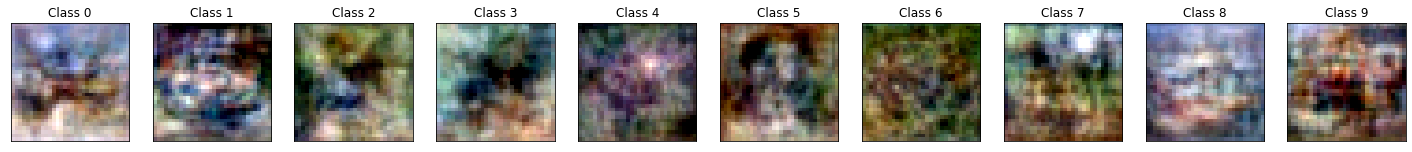

In [ ]:
# Visualize seeds
img_seed = ch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(NUM_CLASSES_VIS)])
img_seed = ch.clamp(img_seed, min=0, max=1)
show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(NUM_CLASSES_VIS)]])

In [ ]:
def generation_loss(mod, inp, targ):
    op = mod(inp)
    loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
    return loss, None

kwargs = {
        'custom_loss': generation_loss,
        'constraint':'2',
        'eps': 40,
        'step_size': 1,
        'iterations': 60,
        'targeted': True,
}  
    
if DATA == 'CIFAR':
    kwargs['eps'] = 30
    kwargs['step_size'] = 0.5
    kwargs['iterations'] = 60

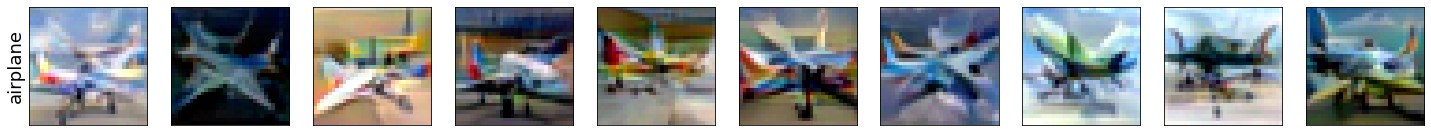

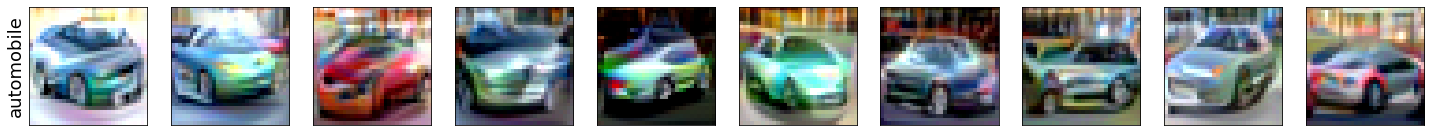

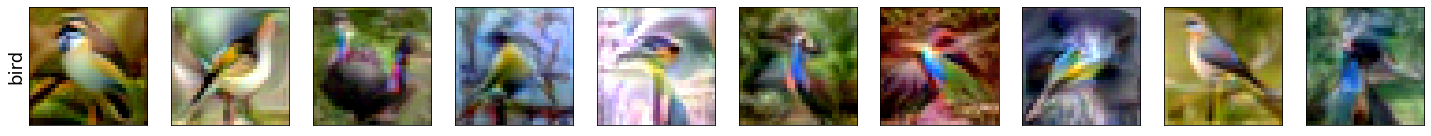

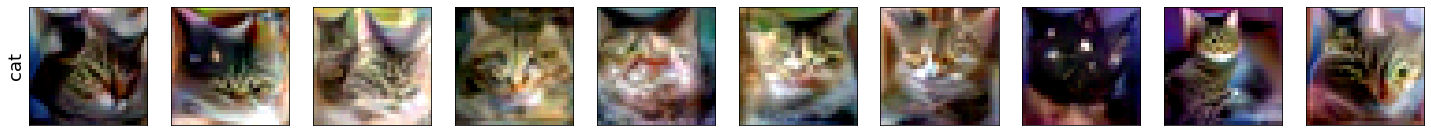

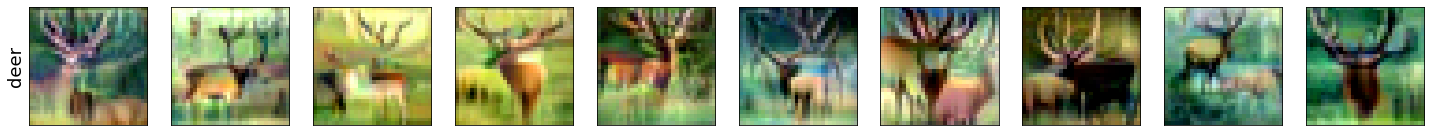

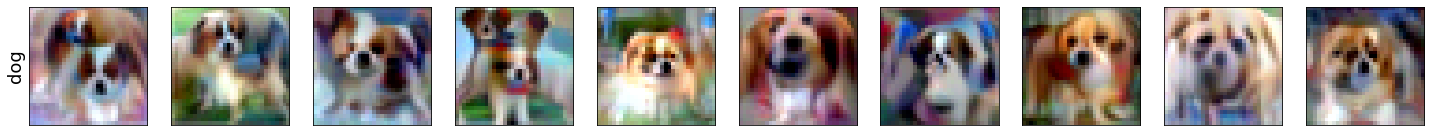

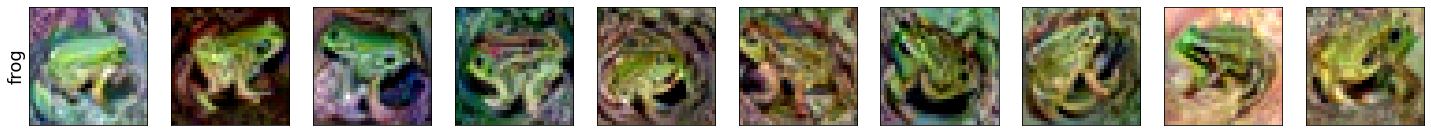

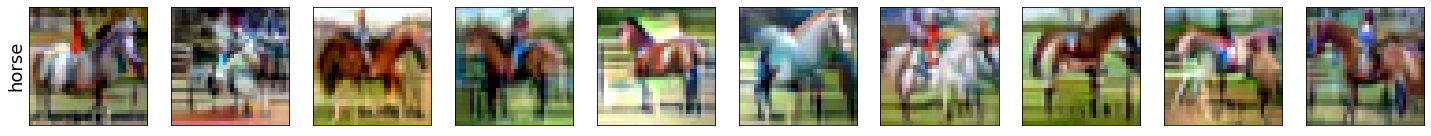

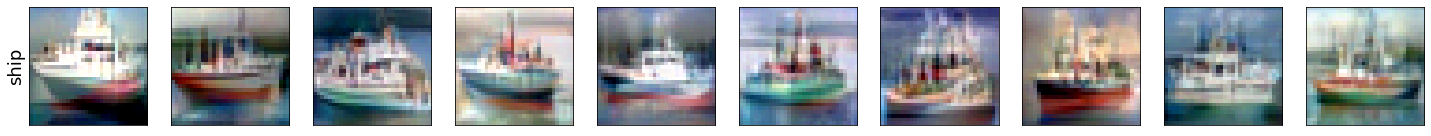

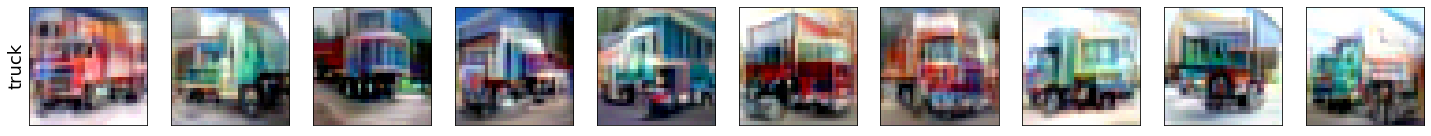

In [ ]:
show_seed = False
for i in range(NUM_CLASSES_VIS):
    target_class = i * ch.ones((BATCH_SIZE, )) 
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    _, im_gen = model(im_seed.to('cuda:0'), target_class.long().to('cuda:0'), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   [CLASSES[int(t)].split(',')[0] for t in target_class], 
                   fontsize=18)

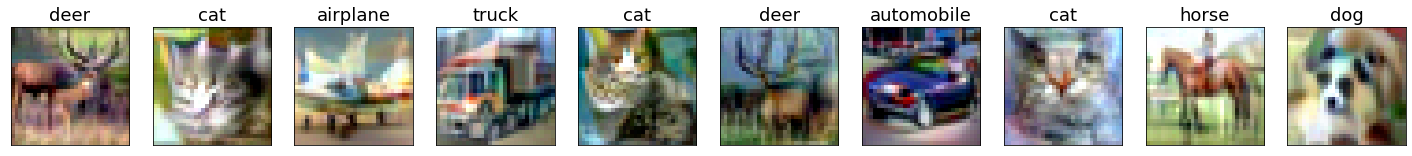

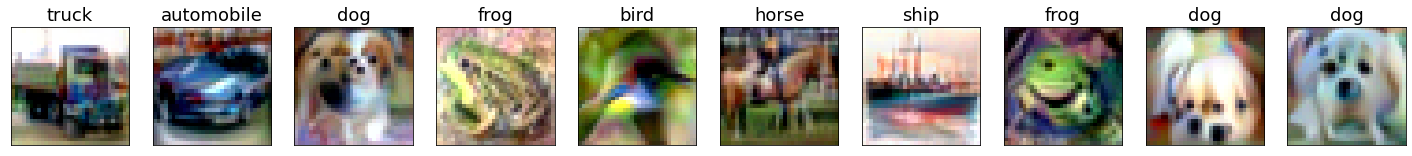

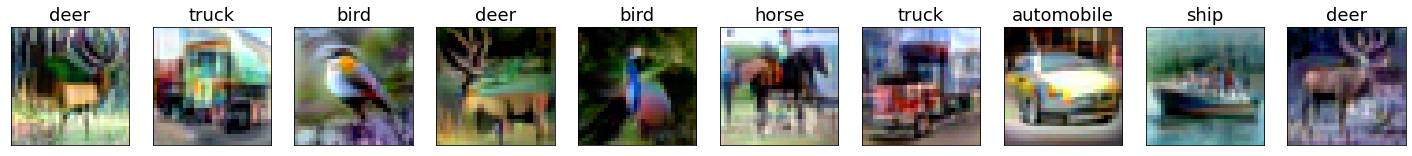

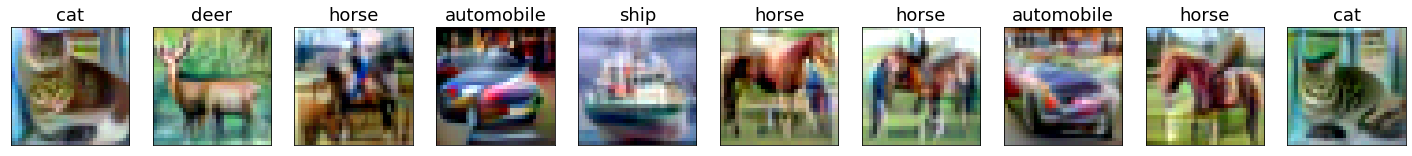

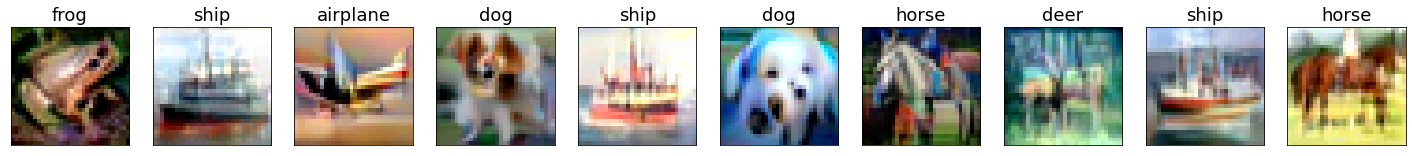

In [ ]:
show_seed = False
for i in range(5):
    target_class = ch.tensor(np.random.choice(range(NUM_CLASSES_VIS), (BATCH_SIZE,)))
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    _, im_gen = model(im_seed.to('cuda:0'), target_class.long().to('cuda:0'), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   tlist=[[CLASSES[int(t)].split(',')[0] for t in target_class]], 
                   fontsize=18)